In [2]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

Acceptance rate for mu = 0.04105410541054105
Acceptance rate for sigma = 0.08955895589558956
Acceptance rate for nu = 0.8313331333133314


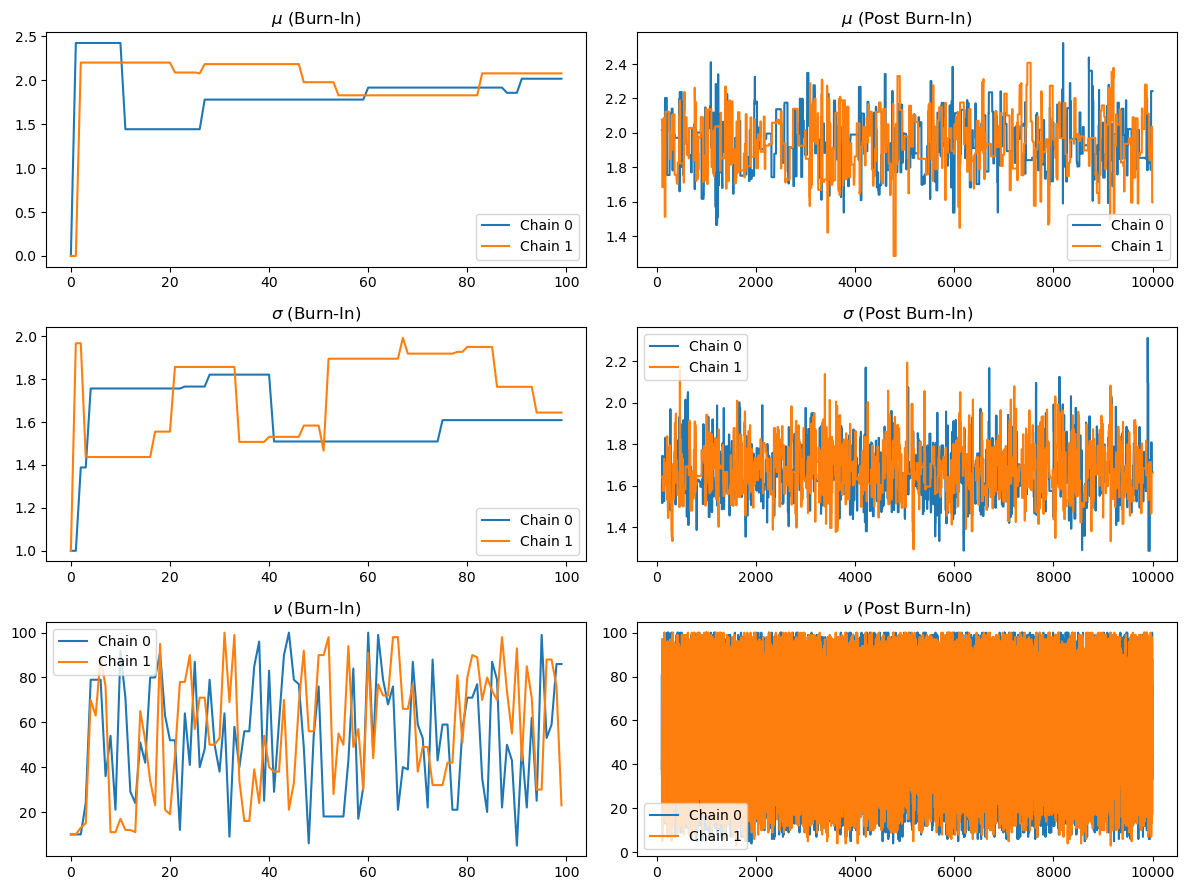

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


n = 100
mu_true = 2.0
sigma_true = 1.5
nu_true = 7  

x = stats.t.rvs(df=nu_true, loc=mu_true, scale=sigma_true, size=n)

mu0 = 0.0
tau0 = 5.0
sigma0 = 3.0
nu_min, nu_max = 1, 100

C = 2          # number of parallel chains
G = 10000       # total MCMC draws
burn_in = 100      # how many draws to treat as burn-in

mu_chain    = np.zeros((C, G))
sigma_chain = np.zeros((C, G))
nu_chain    = np.zeros((C, G), dtype=int)

mu_chain[:, 0] = 0.0
sigma_chain[:, 0] = 1.0
nu_chain[:, 0] = 10  

accept_mu = 0
accept_sigma = 0
accept_nu = 0

def mu_target(mu_, sigma_, nu_):
    if not (nu_min <= nu_ <= nu_max):
        return 0.0
    ll = np.sum(stats.t.logpdf(x, df=nu_, loc=mu_, scale=sigma_))
    lp = stats.norm(mu0, tau0).logpdf(mu_)
    return ll + lp

def sigma_target(sigma_, mu_, nu_):
    if sigma_ <= 0 or not (nu_min <= nu_ <= nu_max):
        return 0.0
    ll = np.sum(stats.t.logpdf(x, df=nu_, loc=mu_, scale=sigma_))
    lp = stats.halfnorm(scale=sigma0).logpdf(sigma_)
    return ll + lp

def nu_target(nu_, mu_, sigma_):
    # If nu_ is not in [1..100], prior is 0 => target=0
    if nu_ < nu_min or nu_ > nu_max:
        return 0.0
    ll = np.sum(stats.t.logpdf(x, df=nu_, loc=mu_, scale=sigma_))
    lp = np.log(1.0 / (nu_max - nu_min + 1))  # discrete uniform prior
    return ll + lp

for c in range(C):
    for g in range(1, G):

        mu_old    = mu_chain[c, g-1]
        sigma_old = sigma_chain[c, g-1]
        nu_old    = nu_chain[c, g-1]

        # proposal for mu
        mu_proposal_dist = stats.norm(loc=mu0, scale=tau0)
        mu_tilde = mu_proposal_dist.rvs()

        numerator   = mu_target(mu_tilde, sigma_old, nu_old) + mu_proposal_dist.logpdf(mu_old)
        denominator = mu_target(mu_old, sigma_old, nu_old) + mu_proposal_dist.logpdf(mu_tilde)
        mh_ratio_mu = numerator - denominator 
        if np.log(np.random.rand()) < min(1.0, mh_ratio_mu):
            mu_chain[c, g] = mu_tilde
            accept_mu += 1
        else:
            mu_chain[c, g] = mu_old

        # proposal for sigma
        sigma_proposal_dist = stats.halfnorm(scale=sigma0)
        sigma_tilde = sigma_proposal_dist.rvs()

        numerator   = sigma_target(sigma_tilde, mu_chain[c, g], nu_old) + sigma_proposal_dist.logpdf(sigma_old)
        denominator = sigma_target(sigma_old, mu_chain[c, g], nu_old) + sigma_proposal_dist.logpdf(sigma_tilde)
        mh_ratio_sigma = numerator - denominator

        if np.log(np.random.rand()) < min(1.0, mh_ratio_sigma):
            sigma_chain[c, g] = sigma_tilde
            accept_sigma += 1
        else:
            sigma_chain[c, g] = sigma_old

        # proposal for nu?
        nu_proposal = np.random.randint(nu_min, nu_max+1)

        numerator   = nu_target(nu_proposal, mu_chain[c, g], sigma_chain[c, g]) + np.log((1.0 / (nu_max - nu_min + 1)))  
        denominator = nu_target(nu_old, mu_chain[c, g], sigma_chain[c, g]) + np.log((1.0 / (nu_max - nu_min + 1)))
        mh_ratio_nu = numerator - denominator

        if np.log(np.random.rand()) < min(1.0, mh_ratio_nu):
            nu_chain[c, g] = nu_proposal
            accept_nu += 1
        else:
            nu_chain[c, g] = nu_old


for c in range(C):
    mu_pre     = mu_chain[c, :burn_in]
    sigma_pre  = sigma_chain[c, :burn_in]
    nu_pre     = nu_chain[c, :burn_in]

    mu_post     = mu_chain[c, burn_in:]
    sigma_post  = sigma_chain[c, burn_in:]
    nu_post     = nu_chain[c, burn_in:]

fig, ax = plt.subplots(3, 2, figsize=(12, 9))

ax[0,0].set_title(r"$\mu$ (Burn-In)")
ax[0,1].set_title(r"$\mu$ (Post Burn-In)")
ax[1,0].set_title(r"$\sigma$ (Burn-In)")
ax[1,1].set_title(r"$\sigma$ (Post Burn-In)")
ax[2,0].set_title(r"$\nu$ (Burn-In)")
ax[2,1].set_title(r"$\nu$ (Post Burn-In)")

for c in range(C):
    ax[0,0].plot(mu_chain[c, :burn_in], label=f"Chain {c}")
    ax[0,1].plot(np.arange(burn_in, G), mu_chain[c, burn_in:], label=f"Chain {c}")

    ax[1,0].plot(sigma_chain[c, :burn_in], label=f"Chain {c}")
    ax[1,1].plot(np.arange(burn_in, G), sigma_chain[c, burn_in:], label=f"Chain {c}")

    ax[2,0].plot(nu_chain[c, :burn_in], label=f"Chain {c}")
    ax[2,1].plot(np.arange(burn_in, G), nu_chain[c, burn_in:], label=f"Chain {c}")

for row in range(3):
    ax[row,0].legend()
    ax[row,1].legend()

plt.tight_layout()
plt.show()

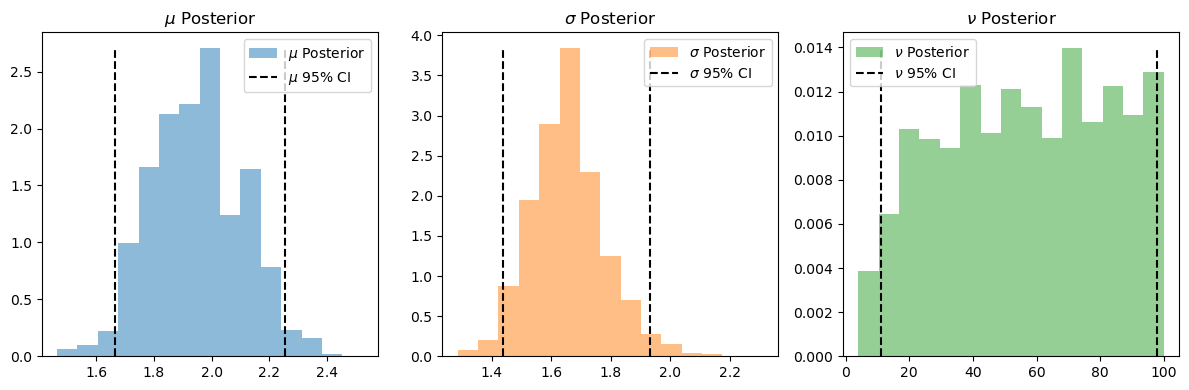

In [29]:

mu_ci = np.percentile(mu_chain[0, burn_in:], [2.5, 97.5])
sigma_ci = np.percentile(sigma_chain[0, burn_in:], [2.5, 97.5])
nu_ci = np.percentile(nu_chain[0, burn_in:], [2.5, 97.5])

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

counts_mu, bins_mu, patches_mu = ax[0].hist(
    mu_chain[0, burn_in:], bins=15, density=True, alpha=0.5, color='C0', label=r"$\mu$ Posterior"
)
ax[0].vlines(mu_ci, ymin=0, ymax=max(counts_mu), colors='k', linestyles='--', label=r"$\mu$ 95% CI")
ax[0].set_title(r"$\mu$ Posterior")
ax[0].legend()

counts_sigma, bins_sigma, patches_sigma = ax[1].hist(
    sigma_chain[0, burn_in:], bins=15, density=True, alpha=0.5, color='C1', label=r"$\sigma$ Posterior"
)
ax[1].vlines(sigma_ci, ymin=0, ymax=max(counts_sigma), colors='k', linestyles='--', label=r"$\sigma$ 95% CI")
ax[1].set_title(r"$\sigma$ Posterior")
ax[1].legend()

counts_nu, bins_nu, patches_nu = ax[2].hist(
    nu_chain[0, burn_in:], bins=15, density=True, alpha=0.5, color='C2', label=r"$\nu$ Posterior"
)
ax[2].vlines(nu_ci, ymin=0, ymax=max(counts_nu), colors='k', linestyles='--', label=r"$\nu$ 95% CI")
ax[2].set_title(r"$\nu$ Posterior")
ax[2].legend()

plt.tight_layout()
plt.show()



0.11755260653490363